# Im2Spec models for predicting property (spectrum) from structure (image)

*  *Notebook prepared by Maxim Ziatdinov  (email: ziatdinovmax@gmail.com)*

*  *The experimental SPM data was collected by Kyle Kelley

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/pycroscopy/SPM_ML_School_2021/blob/main/Day01/Notebooks/SPM_ImSpec.ipynb)
---

This notebook demonstrates usage of encoder-decoder neural networks for predicting spectra (property/functionality) from images (structure) using the *im2spec* deep learning model. In the *im2spec* approach, the sub-images representing a local structure are “compressed” via a convolutional neural network architecture to the small number of latent variables, and the latter are “deconvoluted” to yield the spectra. The architecture of the *im2spec* model is straightforward. It consists of two parts: an encoder for embedding input images into a latent vector and a decoder for generating one-dimensional signals from the embedded features. The encoder part consists of three back-to-back two-dimensional convolutional layers, whereas the decoder part represents a cascade of one-dimensional dilated convolutions with dilation rates of 1, 2, 3, and 4. The dilated convolutions showed superior performance compared to regular convolutional blocks in the decoder. Each convolutional layer in both encoder and decoder parts is formed by running 64 filters (“kernels”) of size 3 on its input and is activated by a leaky rectified linear unit with a negative slope of 0.1. The batch normalization is applied after each activation to avoid overfitting and improve generalization to new data. The “bottleneck” layer for representing the latent vector is a fully connected layer with the number of neurons equal to the specified number of latent dimensions. 

<img src="https://drive.google.com/uc?export=view&id=18cvXfDdpy1Ij-p1T-jALa_nBZ0iRsalW" width=800 px><br><br>


The assumption is of course that there is only a small variability of spectral behaviour within each (sub)-image. Here we are going to apply the *imspec* approach to two different datasets: i) SPM BEPS dataset obtained by Kyle Kelley (see [this](https://pubs.acs.org/doi/abs/10.1021/acsami.0c15085)) paper.


---






Install AtomAI:

In [1]:
!pip install atomai

     |████████████████████████████████| 146 kB 7.9 MB/s 
     |████████████████████████████████| 193 kB 50.4 MB/s 
     |████████████████████████████████| 503 kB 52.8 MB/s 
     |████████████████████████████████| 865 kB 55.9 MB/s 
  Created wheel for mendeleev: filename=mendeleev-0.6.1-py2.py3-none-any.whl size=174982 sha256=2dca8c9a029369f782e3305bf81951c672e6ed4779ae5db807bb4f6af94a3501
  Stored in directory: /root/.cache/pip/wheels/f4/4e/dd/06777c90710ce1766376ecc87979967fe69ff3affc29c0b530
Successfully built mendeleev


Imports:

In [2]:
import atomai as aoi
import numpy as np
import matplotlib.pyplot as plt

(Down)load training data:

## Application to SPM BEPS data

(Down)load training data:

In [3]:
!wget -O "imspec_data.npz" https://www.dropbox.com/s/os0weihai4l1kf8/im2spec.zip?dl=1

dataset = np.load('imspec_data.npz')
imgs = dataset['im2spec_images']
spectra = dataset['im2spec_spectra']
specval = dataset['im2spec_specval']

--2021-10-04 00:33:02--  https://www.dropbox.com/s/os0weihai4l1kf8/im2spec.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/os0weihai4l1kf8/im2spec.zip [following]
--2021-10-04 00:33:02--  https://www.dropbox.com/s/dl/os0weihai4l1kf8/im2spec.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb8494c1e5207ac19e216e2a47a.dl.dropboxusercontent.com/cd/0/get/BXVhLn4oAxzkVTBP76IPDmRP5hruI_vgYpW_tiORLb3vVWmPyRzEqHwuH864YGKlj9n_3tKVO_IaJ6XaDLkUUoPqvnUY_K7BQRO07l9TitDufkEfYYxfrmk662X5oWuzr0ry5Onx6V7FPkhslQ1BtlKv/file?dl=1# [following]
--2021-10-04 00:33:03--  https://ucb8494c1e5207ac19e216e2a47a.dl.dropboxusercontent.com/cd/0/get/BXVhLn4oAxzkVTBP76IPDmRP5hruI_vgYpW_tiORLb3vVWmPyRzEqHwuH864YGKlj9n_3tKVO_IaJ6XaDLkUUoPqvnU

Visualize individual image spectra pairs:

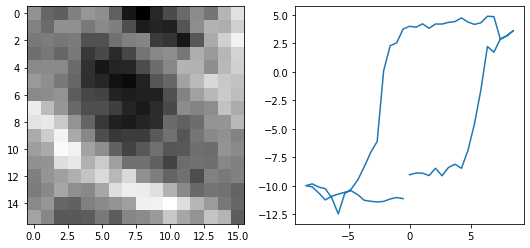

In [4]:
k = 35
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
ax1.imshow(imgs[k], cmap='gray')
ax2.plot(specval[0, :64], spectra[k])

Train-test split:

In [8]:
imgs_train, spectra_train, imgs_test, spectra_test = aoi.utils.data_split(imgs, spectra, format_out="torch_float")

Initialize and train ImSpec model:

/usr/local/lib/python3.7/dist-packages/atomai/utils/preproc.py:89: UserWarning: Adding a channel dimension of 1 to training images
  UserWarning)
/usr/local/lib/python3.7/dist-packages/atomai/utils/preproc.py:94: UserWarning: Adding a channel dimension of 1 to test images
  UserWarning)
/usr/local/lib/python3.7/dist-packages/atomai/utils/preproc.py:99: UserWarning: Adding a channel dimension of 1 to training spectra
  UserWarning)
/usr/local/lib/python3.7/dist-packages/atomai/utils/preproc.py:104: UserWarning: Adding a channel dimension of 1 to test spectra
  UserWarning)


Epoch 1/120 ... Training loss: 26.2655 ... Test loss: 26.1193 ... GPU memory usage: 1021/16280
Epoch 2/120 ... Training loss: 24.8625 ... Test loss: 24.556 ... GPU memory usage: 1021/16280
Epoch 3/120 ... Training loss: 24.4622 ... Test loss: 24.4444 ... GPU memory usage: 1021/16280
Epoch 4/120 ... Training loss: 23.912 ... Test loss: 24.334 ... GPU memory usage: 1021/16280
Epoch 5/120 ... Training loss: 23.6223 ... Test loss: 24.0959 ... GPU memory usage: 1021/16280
Epoch 6/120 ... Training loss: 23.0279 ... Test loss: 23.29 ... GPU memory usage: 1021/16280
Epoch 7/120 ... Training loss: 22.7258 ... Test loss: 22.4632 ... GPU memory usage: 1021/16280
Epoch 8/120 ... Training loss: 22.2042 ... Test loss: 22.1205 ... GPU memory usage: 1021/16280
Epoch 9/120 ... Training loss: 21.8968 ... Test loss: 21.8093 ... GPU memory usage: 1021/16280
Epoch 10/120 ... Training loss: 21.3942 ... Test loss: 21.5081 ... GPU memory usage: 1021/16280
Epoch 11/120 ... Training loss: 21.0562 ... Test loss:

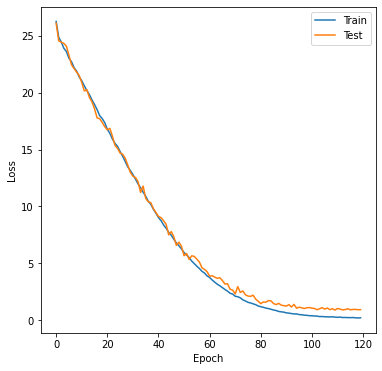

In [9]:
in_dim = (16, 16)
out_dim = (64,)

model = aoi.models.ImSpec(in_dim, out_dim, latent_dim=10, seed=2)

model.fit(imgs_train, spectra_train, imgs_test, spectra_test,  # training data
          full_epoch=True, training_cycles=120, swa=True, batch_norm=True)  # training parameters

Make a prediction with the trained model:

In [10]:
prediction = model.predict(imgs_test, norm=False)

Batch 10/10
174 images were decoded in approximately 0.5312 seconds


Visualize predicted spectra for selected test images:

(note that predictions get improved as if we train longer)

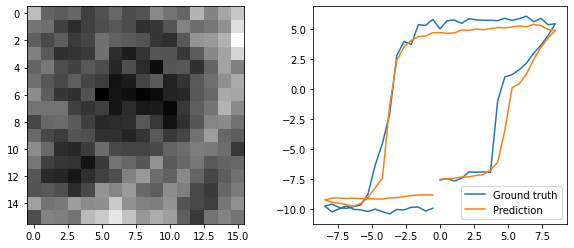

In [11]:
k = 150

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(imgs_test[k], cmap='gray', label="Input image")
ax2.plot(specval[0,:64], spectra_test[k], label="Ground truth")
ax2.plot(specval[0,:64], prediction[k], label="Prediction")
plt.legend()